
# Udacity Capstone Project

# Monkey Breed Classification

In this project, monkey breed classifiaction has beed done with the help of artificial intelligence.
Image classification has beed done to classify images of monkey. to implement this classifiaction a deep learning model is trained on hundreds of images. [this dataset](https://www.kaggle.com/slothkong/10-monkey-species) of 10 monkeys categories, you can see a few examples below. 

<img src='trial_images/n1018.jpg' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content


In [155]:
# Imports basic liabri here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn
from torch import optim
from collections import OrderedDict
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from PIL import Image
import numpy as np

# Load Data
Data is divided into three categories
* Trainng
* Testing
* Validation


In [104]:
data_dir = 'images'
train_dir = data_dir + '/training'
valid_dir = data_dir + '/validation'
test_dir = data_dir + '/testing'

In [149]:
# Categories are loaded 
import json
with open('monkey_breed.json', 'r') as f:
    monkey_breed= json.load(f)

In [106]:
# Defining Transforms for all sets
data_transforms_train = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
data_transforms_test=transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
data_transforms_validation=transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


In [108]:
train_data = datasets.ImageFolder(train_dir, transform=data_transforms_train)
validation_data=datasets.ImageFolder(valid_dir, transform=data_transforms_validation)
test_data = datasets.ImageFolder(test_dir, transform=data_transforms_test)

In [109]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)
validloader=torch.utils.data.DataLoader(validation_data, batch_size=64)

In [110]:
# initialising pre trained network
model = models.densenet121(pretrained=True)

C:\Users\Mandar\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [111]:
# model parameters are defined

for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu1', nn.ReLU()),
                          ('drpot1',nn.Dropout(0.2)) ,
                          ('fc2', nn.Linear(500, 250)),
                          ('relu2', nn.ReLU()),
                          ('drpot2',nn.Dropout(0.2)) ,
                          ('fc3', nn.Linear(250, 10)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
criterion = nn.NLLLoss()   
model.classifier = classifier
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
model.cpu()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [29]:
device = torch.device("cpu")

In [112]:
# Training the network
epochs = 2
steps = 0
running_loss = 0
print_every = 5
model.to('cpu')
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to('cpu'), labels.to('cpu')
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to('cpu:0'), labels.to('cpu:0')
                    model.to('cpu:0')
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                     
                    valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Valid loss: {valid_loss/len(validloader):.3f}.. "
                  f"Valid accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()
       

Epoch 1/2.. Train loss: 2.187.. Valid loss: 1.955.. Valid accuracy: 0.296
Epoch 1/2.. Train loss: 1.781.. Valid loss: 1.260.. Valid accuracy: 0.870
Epoch 2/2.. Train loss: 1.398.. Valid loss: 1.028.. Valid accuracy: 0.593
Epoch 2/2.. Train loss: 1.067.. Valid loss: 0.848.. Valid accuracy: 0.815


In [163]:
# Testing accuracy is calculated 
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
                 
            test_loss += batch_loss.item()
                    
                    # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
print(f"Test loss: {test_loss/len(testloader):.3f}.. "
             f"Test accuracy: {accuracy/len(testloader):.3f}")
running_loss = 0

Test loss: 0.457.. Test accuracy: 1.000


In [114]:
#  Parameters of models are saved
model.class_to_idx = trainloader.dataset.class_to_idx
model.epochs = epochs
checkpoint = {'output_size': 102,
              'state_dict': model.state_dict(),
              'arch':'densenet121',
              'optimizer': optimizer.state_dict(),
              'class_to_idx': model.class_to_idx,
              'epoch': model.epochs
             }

torch.save(checkpoint, 'checkpoint1.pth')

In [115]:
# Function is defined to load network
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.densenet121()
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('drpot',nn.Dropout(0.2)) ,
                          ('fc2', nn.Linear(500, 250)),
                          ('relu', nn.ReLU()),
                          ('drpot',nn.Dropout(0.2)) ,
                          ('fc3', nn.Linear(250, 10)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
    model.classifier = classifier
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# get index to class mapping
loaded_model, class_to_idx = load_checkpoint('checkpoint1.pth')
idx_to_class = dict((val,key) for key,val in class_to_idx.items())

C:\Users\Mandar\Anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


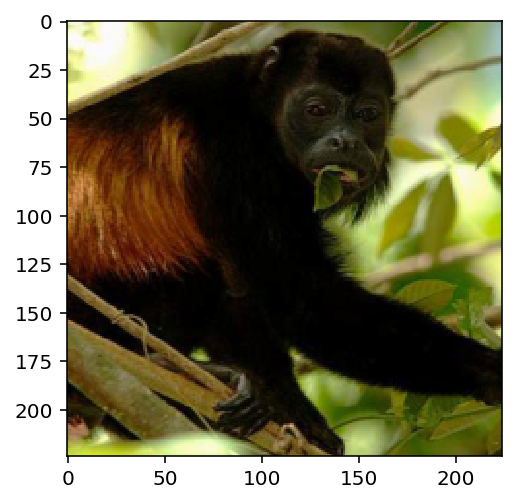

In [117]:
# Function is defined to do preprocessing of image
def process_image(image):
    prepro_img=transforms.Compose([transforms.Resize(255),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
    
    img1=np.array(prepro_img(image))
    return img1
img = 'images/training/0/n0018.jpg'
img=Image.open(img)
p=process_image(img)
imshow(p)

In [70]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    image = np.clip(image, 0, 1)
    
    ax.imshow(np.array(image))
   

    return ax


In [122]:
def predict(image_path, model):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    img=Image.open(image_path)
    t_image=process_image(img)
    t_image=torch.FloatTensor([t_image])
    model.eval()
    output = model.forward(Variable(t_image))
    ps = torch.exp(output)
    ps=ps.detach().numpy()
    ps=ps.reshape(10,)
    chk=np.argsort(ps)
    first_five_index=chk[len(ps)-5:(len(ps))][::-1]
     
    first_five_class = [idx_to_class[i] for i in first_five_index]
    top_probability = ps[first_five_index]
   
    return top_probability, first_five_class

first Five Probabilities are
[0.483329   0.3872819  0.05620372 0.02421811 0.01681833]
first Five Classes are
['0', '9', '5', '2', '8']


<Figure size 432x288 with 0 Axes>

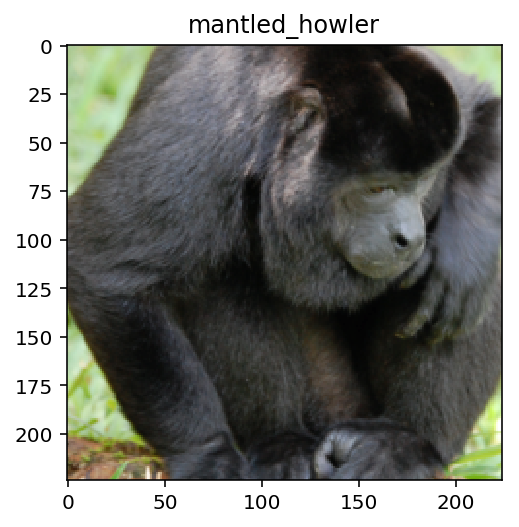

In [165]:
img = 'images/testing/0/n0022.jpg'
img1=Image.open(img)
p=process_image(img1)
fig1=plt.figure()
imshow(p)
plt.title('a')

five_probs,five_class=predict(img,loaded_model)

breed_name = monkey_breed[five_class[0]]
plt.title(breed_name)
print("first Five Probabilities are")
print(five_probs)
print("first Five Classes are")
print(five_class)

Text(0.5,1,'Probs.. Overview')

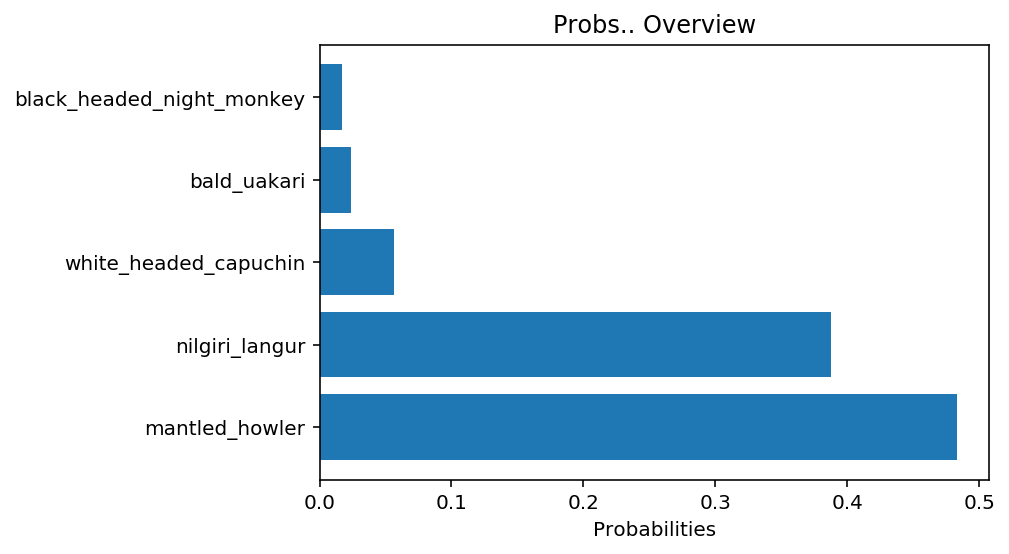

In [166]:
fig2=plt.figure
y_pos = np.arange(len(five_probs))
plt.barh(y_pos, five_probs)
five_class_names = [monkey_breed[i] for i in five_class]
plt.yticks(y_pos,five_class_names)
plt.xlabel("Probabilities")
plt.title("Probs.. Overview")